In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [4]:
_, _, testX, _, _, testY, _, _, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                  'all', 2000, 2020, global_mean, global_Std)

In [6]:
autoencoder_model = tf.keras.models.load_model('models/cae_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim})

In [7]:
test_mse_cae, test_mae_cae, test_psnr_cae, test_ssim_cae = evaluate_per_pixel(autoencoder_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


In [8]:
edsr_model = tf.keras.models.load_model('models/edsr_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [9]:
test_mse_edsr, test_mae_edsr, test_psnr_edsr, test_ssim_edsr = evaluate_per_pixel(edsr_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [10]:
rcan_model = tf.keras.models.load_model('models/rcan_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [11]:
test_mse_rcan, test_mae_rcan, test_psnr_rcan, test_ssim_rcan = evaluate_per_pixel(rcan_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


In [12]:
_, _, testX, _, _, testY, _, _, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std, True, target_size)

In [13]:
srcnn_model = tf.keras.models.load_model('models/srcnn_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim})

In [14]:
test_mse_srcnn, test_mae_srcnn, test_psnr_srcnn, test_ssim_srcnn = evaluate_per_pixel(srcnn_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_models_metrics(metric, cae, srcnn, edsr, adr, colormap):

    # Plot the heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(metric, fontsize=20)

    vmin = min(cae.min(), srcnn.min(), edsr.min(), adr.min())
    vmax = max(cae.max(), srcnn.max(), edsr.max(), adr.max())

    im1 = axes[0, 0].imshow(cae, cmap=colormap, vmin=vmin, vmax=vmax)
    axes[0, 0].set_title("CAE")
    plt.colorbar(im1, ax=axes[0, 0])

    im2 = axes[0, 1].imshow(srcnn, cmap=colormap, vmin=vmin, vmax=vmax)
    axes[0, 1].set_title("SRCNN")
    plt.colorbar(im2, ax=axes[0, 1])

    im3 = axes[1, 0].imshow(edsr, cmap=colormap, vmin=vmin, vmax=vmax)
    axes[1, 0].set_title("EDSR")
    plt.colorbar(im3, ax=axes[1, 0])

    im4 = axes[1, 1].imshow(adr, cmap=colormap, vmin=vmin, vmax=vmax)
    axes[1, 1].set_title("ADR")
    plt.colorbar(im4, ax=axes[1, 1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

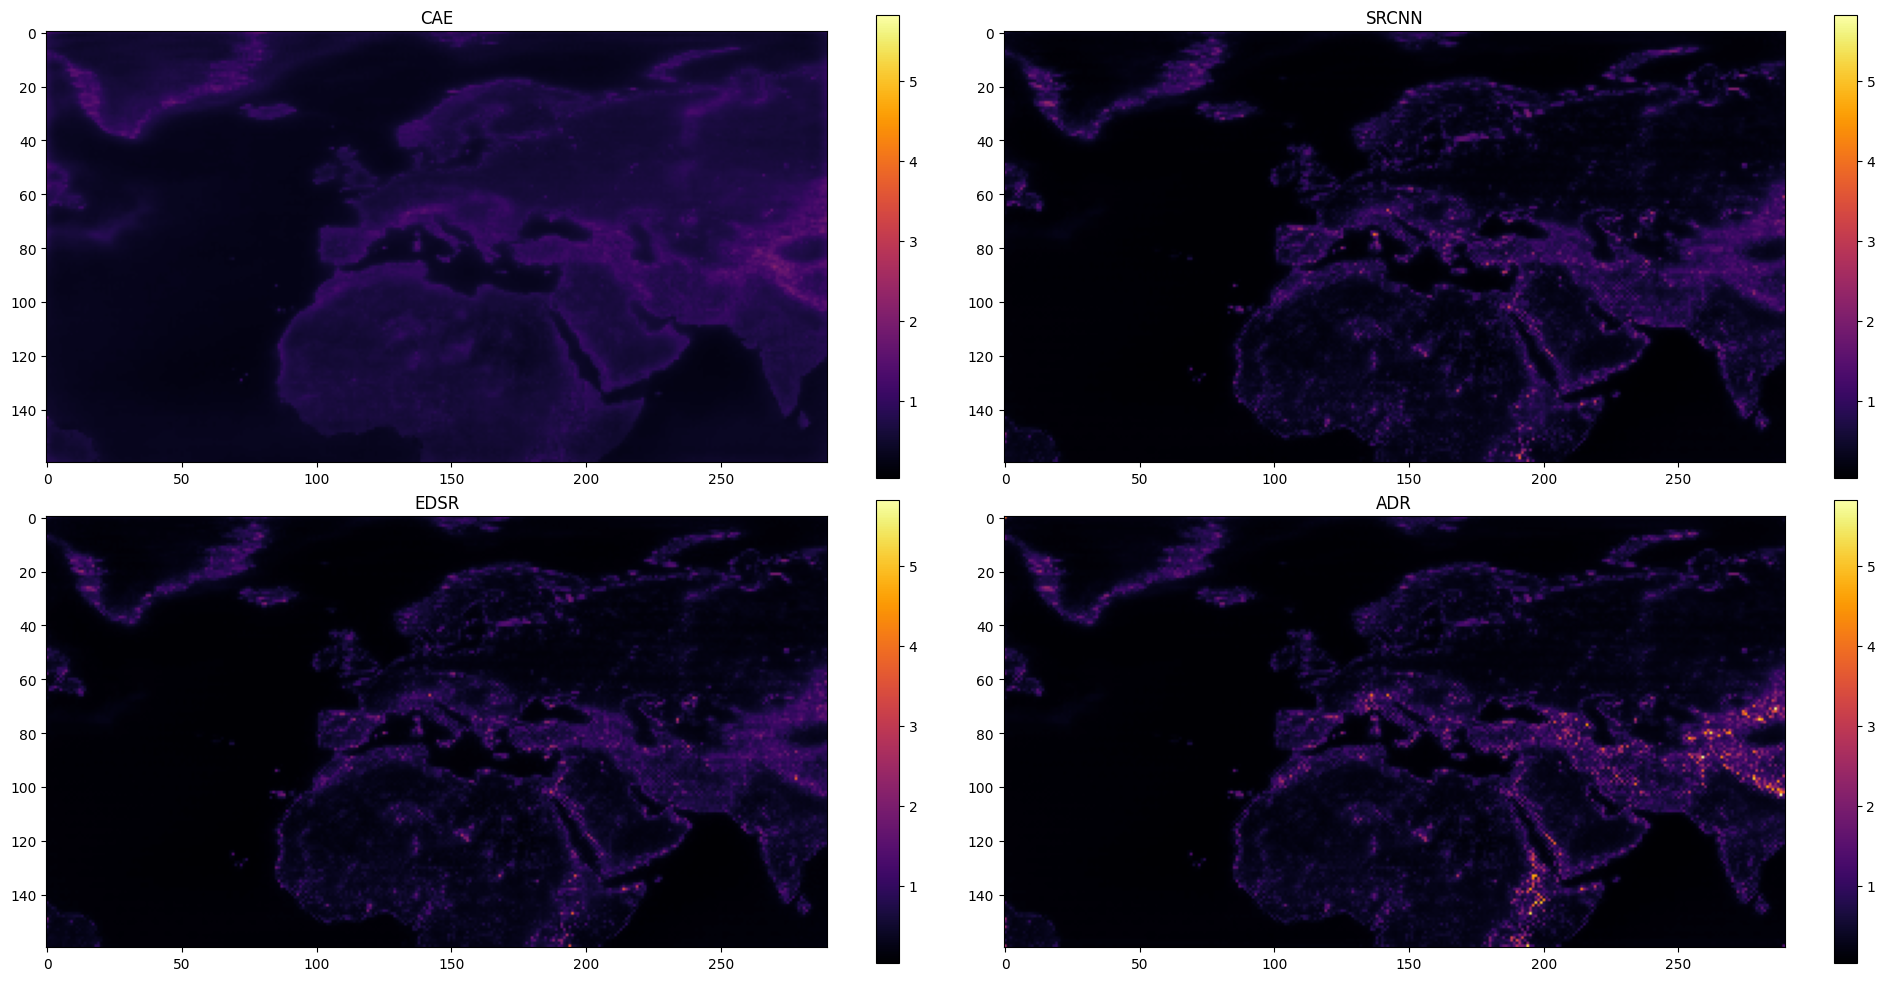

In [16]:
degrees_mae_cae = denormalize_mae(test_mae_cae, global_Std)
degrees_mae_srcnn = denormalize_mae(test_mae_srcnn, global_Std)
degrees_mae_edsr = denormalize_mae(test_mae_edsr, global_Std)
degrees_mae_rcan = denormalize_mae(test_mae_rcan, global_Std)
plot_models_metrics('', degrees_mae_cae, degrees_mae_srcnn, degrees_mae_edsr, degrees_mae_rcan, 'inferno')

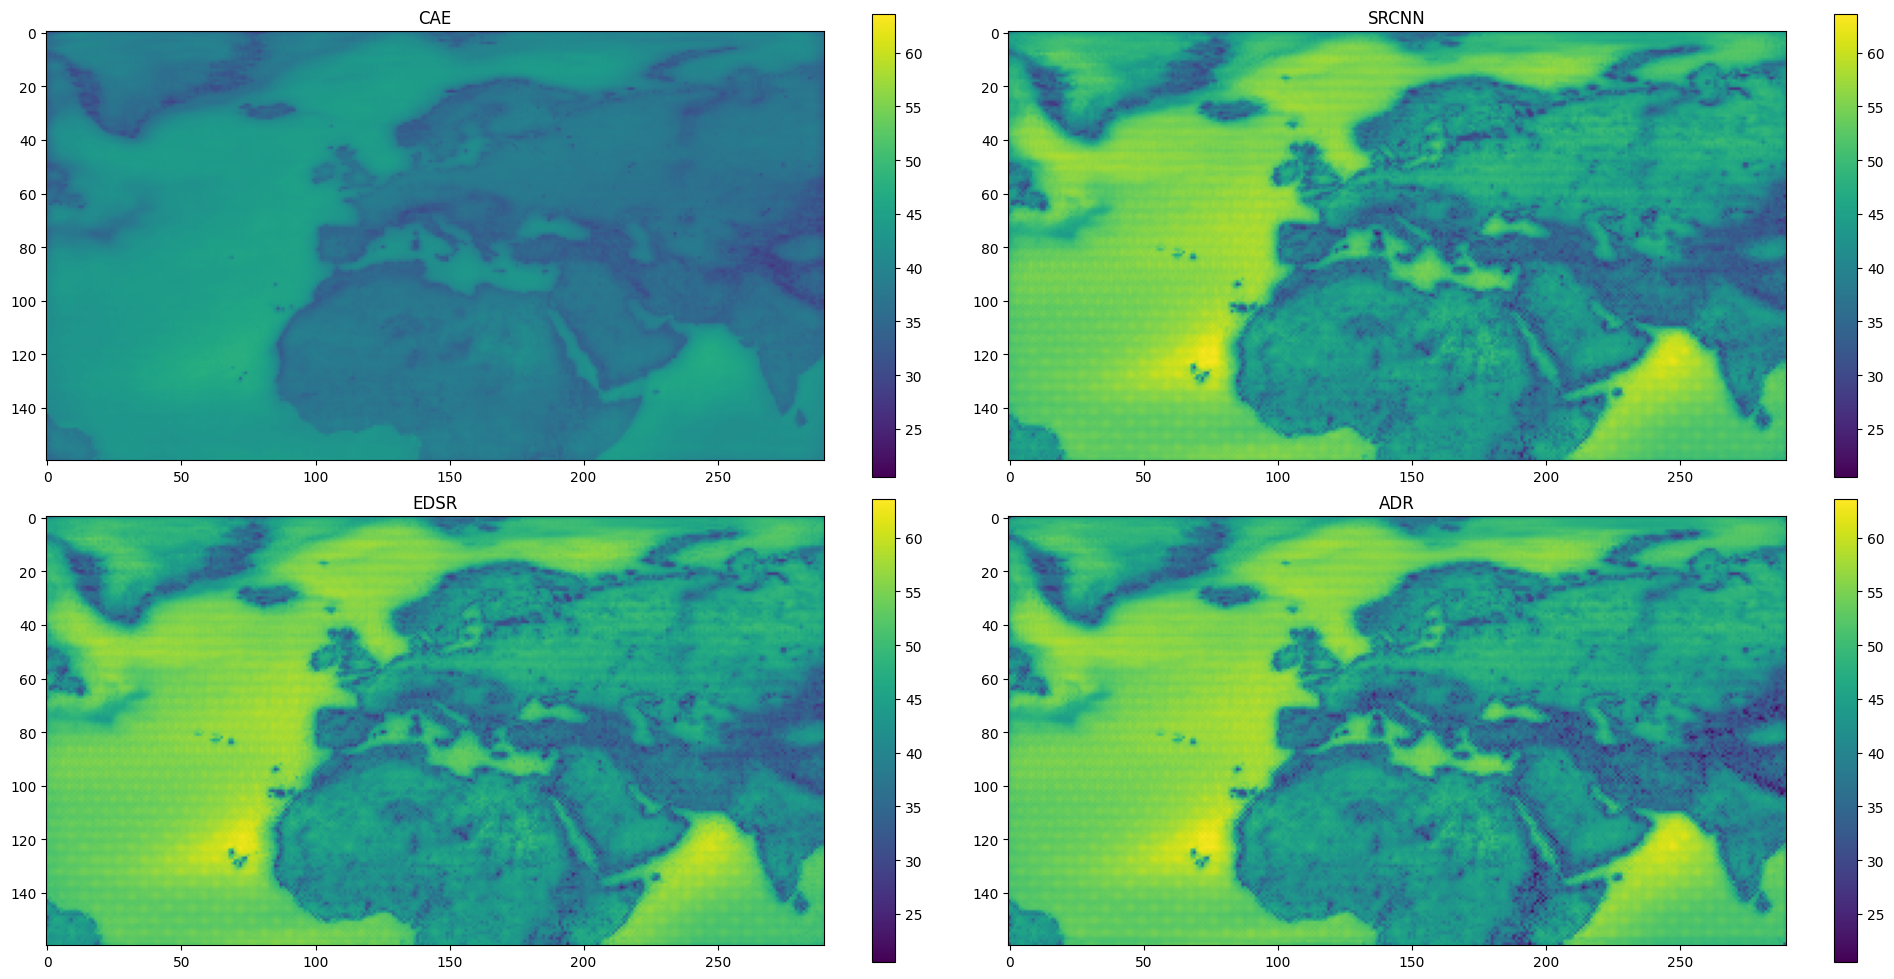

In [17]:
plot_models_metrics('', test_psnr_cae, test_psnr_srcnn, test_psnr_edsr, test_psnr_rcan, 'viridis')

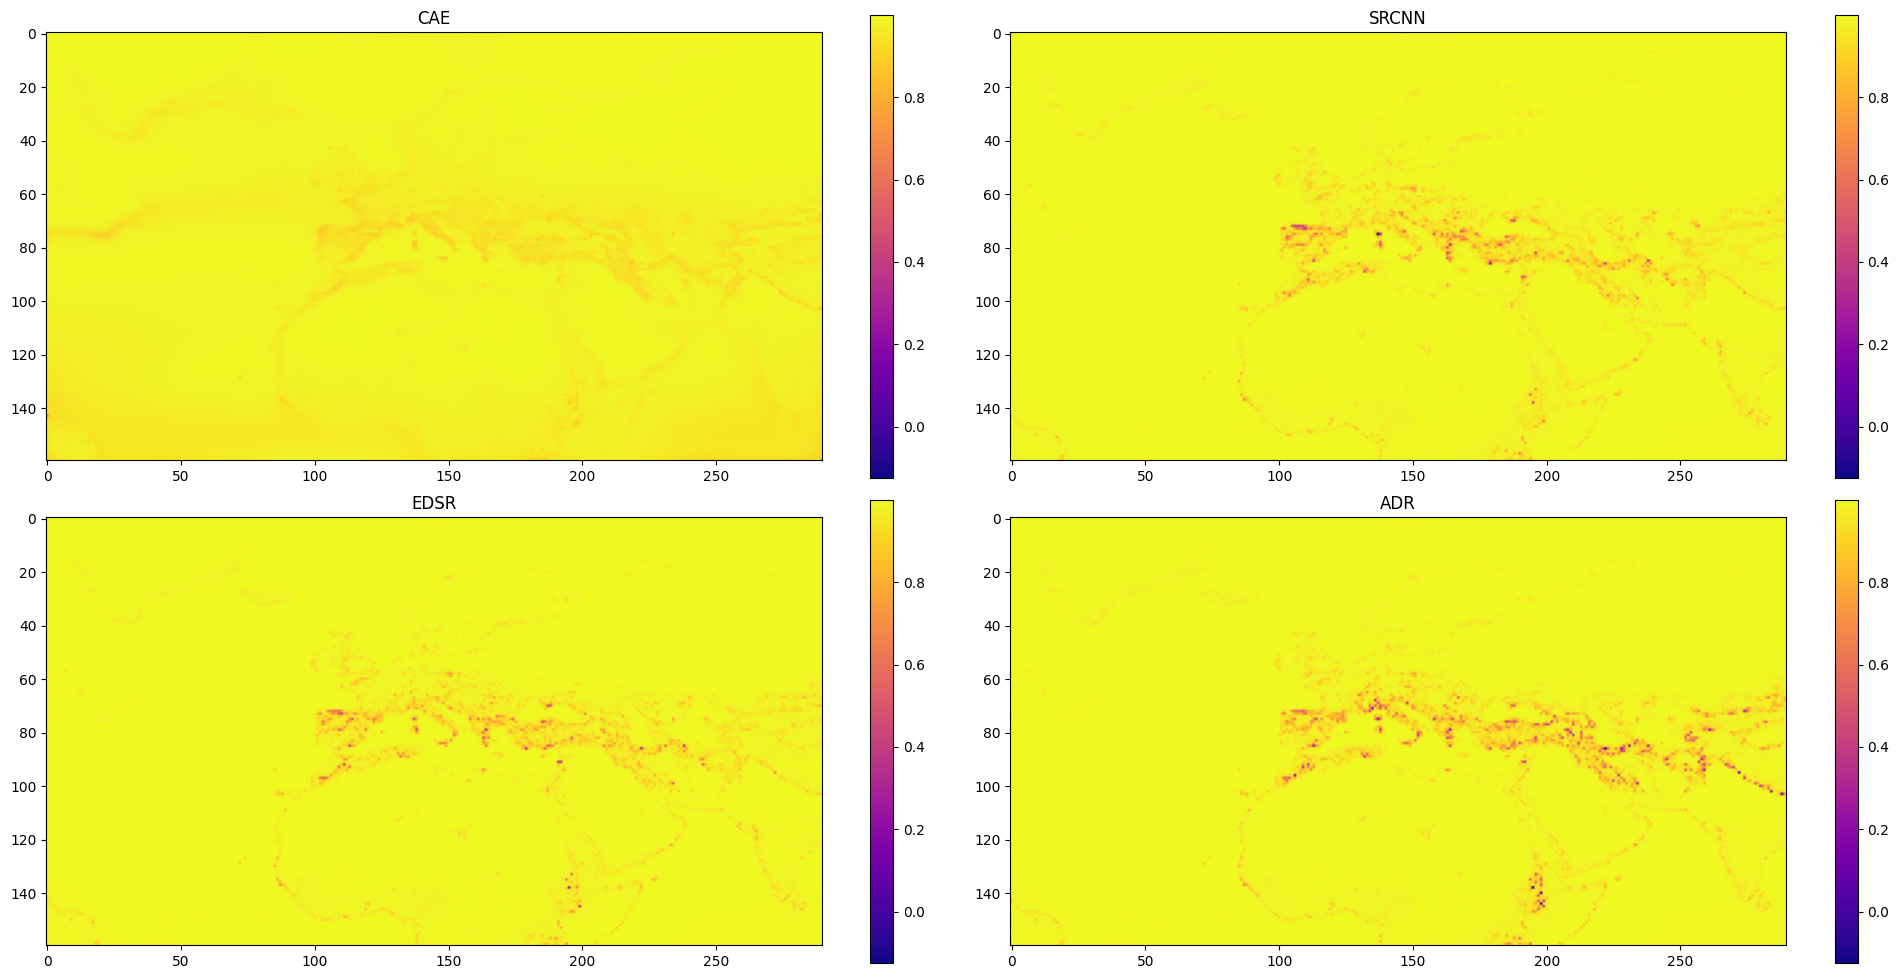

In [19]:
plot_models_metrics('', test_ssim_cae, test_ssim_srcnn, test_ssim_edsr, test_ssim_rcan, 'plasma')

In [37]:
_, _, testX, _, _, testY, _, _, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                  'all', 2000, 2020, global_mean, global_Std)

In [38]:
low_res_input = testX[1]
high_res_data = testY[1]

In [22]:
high_res_output_cae = autoencoder_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [23]:
high_res_output_edsr = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


In [24]:
high_res_output_rcan = rcan_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


In [25]:
_, _, testX, _, _, testY, _, _, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std, True, target_size)

In [26]:
high_res_output_srcnn = srcnn_model.predict(np.expand_dims(testX[1], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


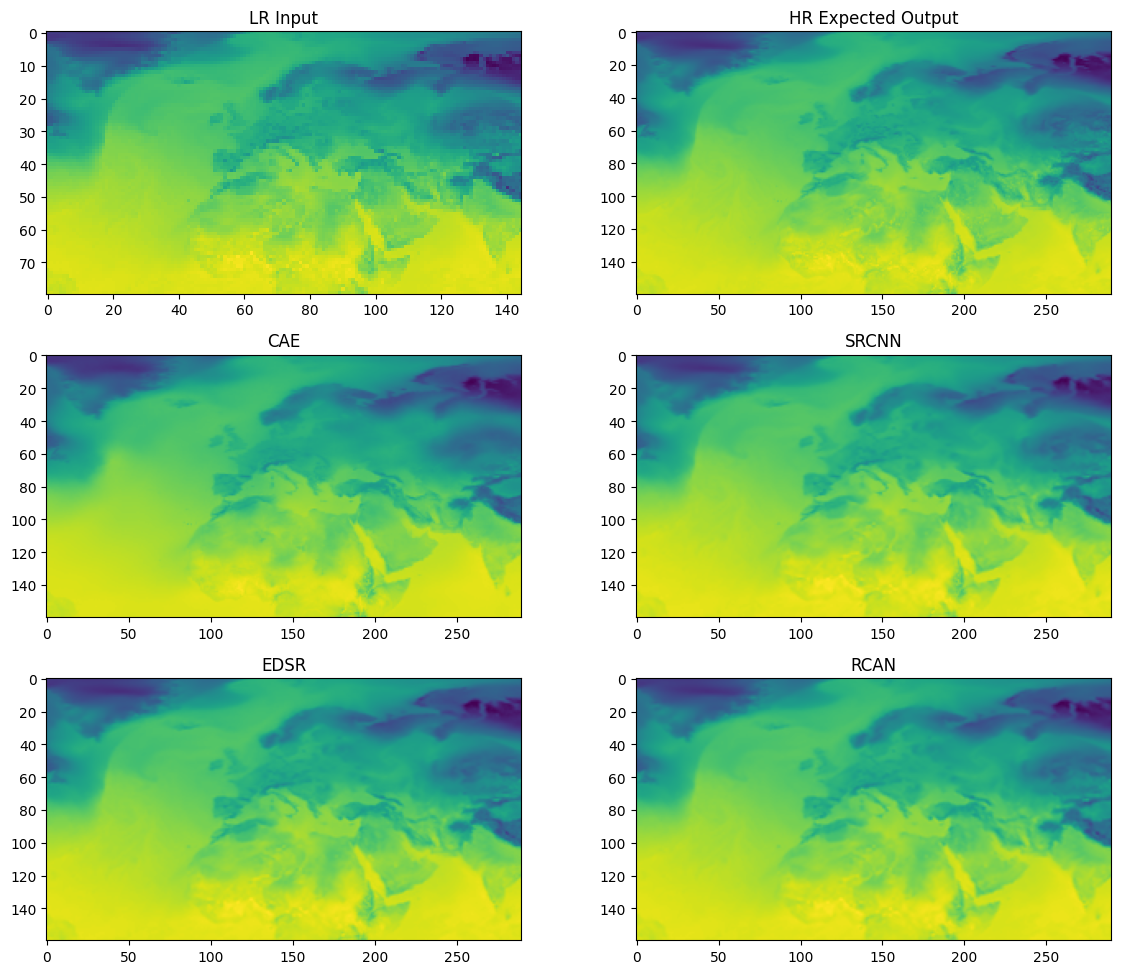

In [40]:
# Plot the heatmaps
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle('', fontsize=20)


im1 = axes[0, 0].imshow(low_res_input, cmap='viridis')
axes[0, 0].set_title("LR Input")

im2 = axes[0, 1].imshow(high_res_data, cmap='viridis')
axes[0, 1].set_title("HR Expected Output")

im3 = axes[1, 0].imshow(np.squeeze(high_res_output_cae), cmap='viridis')
axes[1, 0].set_title("CAE")

im4 = axes[1, 1].imshow(np.squeeze(high_res_output_srcnn), cmap='viridis')
axes[1, 1].set_title("SRCNN")

im5 = axes[2, 0].imshow(np.squeeze(high_res_output_edsr), cmap='viridis')
axes[2, 0].set_title("EDSR")

im6 = axes[2, 1].imshow(np.squeeze(high_res_output_rcan), cmap='viridis')
axes[2, 1].set_title("RCAN")

# Adjust layout
plt.tight_layout()
plt.show()